# Anamoly Detection

* Detecting the unexpected!
* Identifying the outliers

### Examples

* Network Intrusion
* Credit Card Fraud
* Fault in production pipeline
* An epidemic

## Can AI help?

* The process should be automated
* Should happen in real-time


#### Important feature/assumption

* Anomalies only occur rarely in the data.
* Their input features differ from the normal instances significantly.


## Task: Identify fraudulent credit card transactions

Credit card companies should be able to recognize fraudulent credit card transactions so that customers are not charged for products that they have not purchased.

### Dataset

We will be using the dataset collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. The datasets contains transactions made by credit cards in September 2013 by european cardholders. The dataset is avilable under [open database license](https://opendatacommons.org/licenses/dbcl/1-0/).

The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.




## Program structure

While Jupyter Notebooks are a great way to learn, they are not compatible with production. Thus for making a production ready code, it is important that we follow a structure. 
To solve this problem we will be following a simple program structure using the concepts of modularity and abstraction.
The code is divided in three sections:
* **Utility functions**: All the helper functions like downloading data, preprocessing the data, additional plotting functionalities come here. We will call this `util.py`. 
* **Model definition**: This contains the model that you want to use. We will place this in file `model.py`.
* **Main Code**: Finally the code using the utility functions and model will be placed here, where we will do training and later prediction. This code is called `main.py`.

![](https://drive.google.com/uc?export=view&id=1aqymDLGBChMZSHcFTVUXjMpb2hT6OklO)

We will follow this structure in the example baseline.

In [ ]:
%%writefile util.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt

def download_data(url):
  '''
  The function downloads data from the url and preprocesses it. 
  The function uses SMOTE to handle class imbalance
  Arguments
  url: The url link from where to download data
  Returns:
  X_sm, y_sm:  Balanced training dataset
  X_test, y_test: Test dataset 
  '''
  df = pd.read_csv(url)
  #creating target series
  target = df['Class']

  #dropping the target variable from the data set
  df.drop('Class',axis=1,inplace=True)

  #converting them to numpy arrays
  X = np.array(df)
  y = np.array(target)

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

  ## Handle class imbalance
  sm = SMOTE(random_state=2)
  X_sm,y_sm = sm.fit_resample(X_train,y_train)

  return X_sm, y_sm, X_test, y_test

def calculate_metrics(y_test, y_logreg,y_logreg_prob):
  '''
  The function uses Scikit to calculate metrics for the model. The metrics given are:
  * Confusion Matrix
  * Accuracy
  * Precision
  * Recall
  * AUC
  * AUPRC
  * Top-k Accuracy
  '''
  print("Confusion Matrix:\n",metrics.confusion_matrix(y_test,y_logreg))
  print("Accuracy:\n",metrics.accuracy_score(y_test,y_logreg))
  print("Precision:\n",metrics.precision_score(y_test,y_logreg))
  print("Recall:\n",metrics.recall_score(y_test,y_logreg))
  print("AUC:\n",metrics.roc_auc_score(y_test,y_logreg_prob))
  print("AUPRC:\n",metrics.average_precision_score(y_test,y_logreg_prob))
  print("Top-k Accuracy:\n",metrics.top_k_accuracy_score(y_test,y_logreg_prob))



def save_auc(y_test,y_logreg_prob):
  '''
  The function saves the AUC curve in a file
  '''
  auc=metrics.roc_auc_score(y_test,y_logreg_prob)
  fpr,tpr,thresholds=metrics.roc_curve(y_test,y_logreg_prob)
  plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
  plt.plot([0,1],[0,1],'r-.')
  plt.xlim([-0.2,1.2])
  plt.ylim([-0.2,1.2])
  plt.title('Receiver Operating Characteristic\nLogistic Regression')
  plt.legend(loc='lower right')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.savefig("Auc_curve.png")

  



Overwriting util.py


In [ ]:
%%writefile model.py

import numpy as np
from sklearn.linear_model import LogisticRegression
def train(X_sm,y_sm):
  '''
  Function takes in the training data, define a Logistic Regression model
  and train the model.
  Arguments:
  X_sm,y_sm: The taining data with label
  Returns
  model: The trained model
  
  '''
  #Logistic Regression
  model=LogisticRegression()
  model.fit(X_sm,y_sm)
  return model 

def predict(X_test,model):
  '''
  Function predicts the output for a given input array
  Arguments
  X_test: The input dataset for which you want to predict
  model: The trained model
  Returns
  y_logreg: The output of the trained logistic regressor
  y_logreg_prob: The probability/confidence value of the prediction
  '''
  y_logreg = model.predict(X_test)
  y_logreg_prob = model.predict_proba(X_test)[:,1]
  return y_logreg, y_logreg_prob


Overwriting model.py


In [ ]:
%%writefile main.py

import numpy as np
from util import download_data, calculate_metrics, save_auc
from model import train, predict


url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"

## read data:
X_sm, y_sm, X_test, y_test = download_data(url)

#define and train the model:
model = train(X_sm, y_sm)

# Make predictions
y_logreg, y_logreg_prob = predict(X_test,model)

#Calculate metrics
calculate_metrics(y_test, y_logreg,y_logreg_prob)

#Save AUC curve
save_auc(y_test,y_logreg_prob)


Overwriting main.py


In [ ]:
!python -W ignore main.py

Confusion Matrix:
 [[70180   911]
 [   17    94]]
Accuracy:
 0.9869666582399371
Precision:
 0.09353233830845771
Recall:
 0.8468468468468469
AUC:
 0.9624665810258924
AUPRC:
 0.6601412181295772
Top-k Accuracy:
 1.0


Let us see the AUC curve obtained


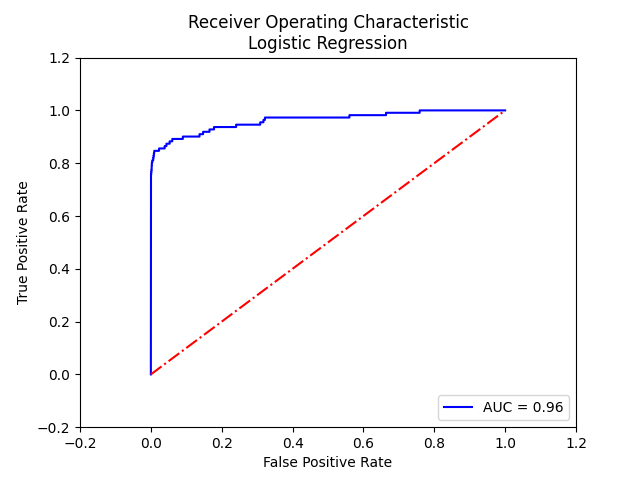

In [ ]:
from IPython.display import Image
Image(filename='Auc_curve.png')

## Exercise 1

Discuss evaluation metrics. Which ones are more important for anomaly detection problems


**Answer:**

Based from the results generated from 5 different metrics: 

    Confusion Matrix:   [[70180   911]
                        [   17    94]]

    Accuracy:           0.9869666582399371

    Precision:          0.09353233830845771

    Recall:             0.8468468468468469

    AUC:                0.9624665810258924

**Performance:**

    Accuracy:           98.70 %      # Same as Confusion Matrix

    Precision:           9.35 %

    Recall:             84.68 %

    AUC:                96.25 %

**Overall, the Accuracy/Confusion Matrix metric yields the best performance. However, as previously mentioned, it is not meaningful for imbalanced classification.**

## Exercise 2

Try to improve on the Logistic Regression result. Follow the suggested code structure

**Answer:**

By exploring and implementing the AUPRC & Top-k Accuracy metrics, Top-k Accuracy metric obtained a 100% accuracy. However, I am uncertain if the results are correct.

    Confusion Matrix:   [[70180   911]
                        [   17    94]]

    Accuracy:           0.9869666582399371

    Precision:          0.09353233830845771

    Recall:             0.8468468468468469

    AUC:                0.9624665810258924

    AUPRC:              0.6601412181295772

    Top-k Accuracy:     1.0

**Performance:**

    Accuracy:           98.70 %      # Same as Confusion Matrix

    Precision:           9.35 %

    Recall:             84.68 %

    AUC:                96.25 %

    AUPRC:              66.01 %

    Top-k Accuracy:    100.00 %

### References

* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

* Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

* Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019